#  import stuff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pathlib import Path
from pprint import pprint
from tqdm import tqdm
# import featuretools as ft
from joblib import dump, load
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from  sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from tensorflow.keras import layers,models,metrics,callbacks,losses
from tensorflow.keras.activations import relu,sigmoid,swish,tanh,selu
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Adadelta,Nadam
from tensorflow.keras.models import Model, Sequential,load_model
import tensorflow as tf

RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
import warnings
warnings.filterwarnings(
    action='ignore',
)

In [2]:
metadata = pd.read_csv('../input/is-this-crazy/metadata.csv')
sup_metadata = pd.read_csv('../input/is-this-crazy/supplemental_metadata.csv')
train_labels = pd.read_csv('../input/is-this-crazy/train_labels.csv', index_col="sample_id")
val_labels = pd.read_csv('../input/is-this-crazy/val_labels.csv',index_col='sample_id')
# targets = pd.read_csv('targets.csv',index_col='sample_id')
submission_format = pd.read_csv('../input/is-this-crazy/submission_format.csv')

In [3]:
targets = pd.concat([train_labels,val_labels],axis=0)

# Load data

In [4]:
%%time
test_100 = pd.read_csv('../input/ms-gen-train-test-data/test_100.csv',index_col=0,header=[0,1])
train_100 = pd.read_csv('../input/ms-gen-train-test-data/train_100.csv',index_col=0,header=[0,1])
val_100 = pd.read_csv('../input/ms-gen-train-test-data/val_100.csv',index_col=0,header=[0,1])

val_100.index = metadata[metadata.split == 'val'].sample_id

val_100.sort_index(inplace=True,axis=1)
test_100.sort_index(inplace=True,axis=1)
train_100.sort_index(inplace=True,axis=1)

CPU times: user 1.1 s, sys: 117 ms, total: 1.21 s
Wall time: 1.55 s


In [5]:
%%time
train_5 = pd.read_csv('../input/ms-gen-train-test-data/train_5.csv',index_col=0,header=[0,1])
val_5 = pd.read_csv('../input/ms-gen-train-test-data/val_5.csv',index_col=0,header=[0,1])
test_5 = pd.read_csv('../input/ms-gen-train-test-data/test_5.csv',index_col=0,header=[0,1])

test_5.sort_index(inplace=True,axis=1)
val_5.sort_index(inplace=True,axis=1)
train_5.sort_index(inplace=True,axis=1)

CPU times: user 1min 33s, sys: 2.98 s, total: 1min 36s
Wall time: 1min 42s


In [6]:
%%time
train_3 = pd.read_csv('../input/ms-gen-train-test-data/train_3.csv',index_col=0,header=[0,1])
val_3 = pd.read_csv('../input/ms-gen-train-test-data/val_3.csv',index_col=0,header=[0,1])
test_3 = pd.read_csv('../input/ms-gen-train-test-data/test_3.csv',index_col=0,header=[0,1])

test_3.sort_index(inplace=True,axis=1)
val_3.sort_index(inplace=True,axis=1)
train_3.sort_index(inplace=True,axis=1)

CPU times: user 4min 49s, sys: 7.43 s, total: 4min 56s
Wall time: 5min 5s


In [7]:
%%time
train_50 = pd.read_csv('../input/ms-gen-train-test-data/train_50.csv',index_col=0,header=[0,1])
test_50 = pd.read_csv('../input/ms-gen-train-test-data/test_50.csv',index_col=0,header=[0,1])
val_50 = pd.read_csv('../input/ms-gen-train-test-data/val_50.csv',index_col=0,header=[0,1])

test_50.sort_index(inplace=True,axis=1)
train_50.sort_index(inplace=True,axis=1)
val_50.sort_index(inplace=True,axis=1)

CPU times: user 2.56 s, sys: 51.1 ms, total: 2.61 s
Wall time: 3.19 s


In [8]:
train_200 = pd.read_csv('../input/ms-gen-train-test-data/train_200.csv',index_col=0,header=[0,1])
val_200 = pd.read_csv('../input/ms-gen-train-test-data/val_200.csv',index_col=0,header=[0,1])
test_200 = pd.read_csv('../input/ms-gen-train-test-data/test_200.csv',index_col=0,header=[0,1])

test_200.sort_index(inplace=True,axis=1)
val_200.sort_index(inplace=True,axis=1)
train_200.sort_index(inplace=True,axis=1)

train_200.shape

(766, 1000)

In [9]:
train_500 = pd.read_csv('../input/ms-gen-train-test-data/train_500.csv',index_col=0,header=[0,1])
val_500 = pd.read_csv('../input/ms-gen-train-test-data/val_500.csv',index_col=0,header=[0,1])
test_500 = pd.read_csv('../input/ms-gen-train-test-data/test_500.csv',index_col=0,header=[0,1])

test_500.sort_index(inplace=True,axis=1)
val_500.sort_index(inplace=True,axis=1)
train_500.sort_index(inplace=True,axis=1)

In [10]:
train_500.shape, train_200.shape, train_100.shape, train_50.shape, train_5.shape, train_3.shape

((766, 400), (766, 1000), (766, 2100), (766, 4200), (766, 42000), (766, 70000))

In [11]:
train_set_3 = pd.concat([train_3,val_3],axis=0)
train_set_5 = pd.concat([train_5,val_5],axis=0)
train_set_50 = pd.concat([train_50,val_50],axis=0)
train_set_100 = pd.concat([train_100,val_100],axis=0)
train_set_200 = pd.concat([train_200,val_200],axis=0)
train_set_500 = pd.concat([train_500,val_500],axis=0)

In [12]:
test_set_3 = pd.concat([val_3,test_3],axis=0)
test_set_5 = pd.concat([val_5,test_5],axis=0)
test_set_50 = pd.concat([val_50,test_50],axis=0)
test_set_100 = pd.concat([val_100,test_100],axis=0)
test_set_200 = pd.concat([val_200,test_200],axis=0)
test_set_500 = pd.concat([val_500,test_500],axis=0)

# total abundance
- this varies coz of min max scaling...

In [13]:
def get_mz(mz,df):
    ''' returns list of columns for given mz'''
    cols_list = []
    for col in df.columns:
        if col[0] == str(mz):
            cols_list.append(col)
    return cols_list

In [14]:
def get_total_abundance(df):
    ''' returns total abundance for each sample'''
    tot_abund_df = pd.DataFrame(index=df.index)
    tot_abund_df['tot_abund'] = df.sum(axis=1)
    for mz in tqdm(range(0,100)):
        tot_abund_df[f"tot_abund_{mz}"] = df[get_mz(mz,df)].sum(axis=1)
    return tot_abund_df

In [15]:
tot_abund_3 = get_total_abundance(train_set_3)
tot_abund_200 = get_total_abundance(train_set_200)
tot_abund_50 = get_total_abundance(train_set_50)
tot_abund_5 = get_total_abundance(train_set_5)
tot_abund_100 = get_total_abundance(train_set_100)
tot_abund_500 = get_total_abundance(train_set_500)

100%|██████████| 100/100 [00:00<00:00, 264.36it/s]


In [16]:
tot_abund_5_test = get_total_abundance(test_set_5)
tot_abund_3_test = get_total_abundance(test_set_3)
tot_abund_50_test = get_total_abundance(test_set_50)
tot_abund_100_test = get_total_abundance(test_set_100)
tot_abund_200_test = get_total_abundance(test_set_200)
tot_abund_500_test = get_total_abundance(test_set_500)

100%|██████████| 100/100 [00:00<00:00, 267.36it/s]


In [17]:
# def get_tempbins(mz):
#     col_list = []
#     for col in train_df.columns:
#         if col[0] == str(mz):
#             col_list.append(col)
#     return col_list

In [18]:
# drop if all values are zero
def check_col(df):
    col_with_zeros = []
    for id,col in enumerate(tqdm(df.columns)):
        if df[col].nunique() == 1:
            col_with_zeros.append(id)
    return col_with_zeros

# get gradients

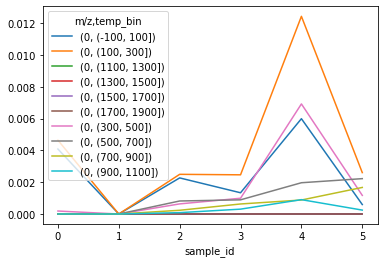

In [19]:
train_set_200.loc[:5,get_mz(0,train_set_200)].plot();

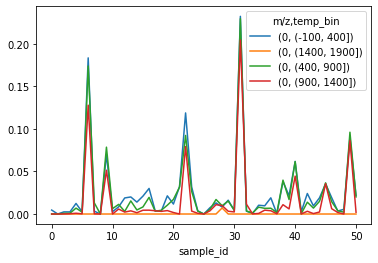

In [20]:
train_set_500.loc[:50,get_mz(0,train_set_500)].plot();

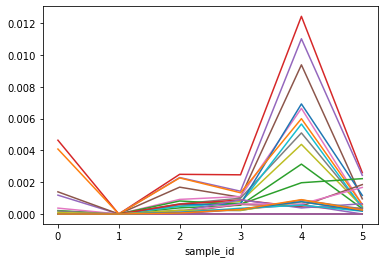

In [21]:
train_set_50.loc[:5,get_mz(0,train_set_50)].plot(legend=False);

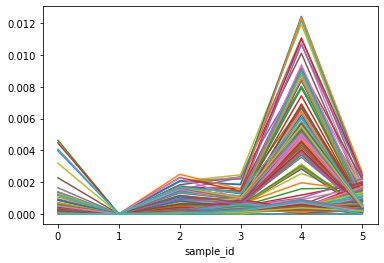

In [22]:
train_set_5.loc[:5,get_mz(0,train_set_5)].plot(legend=False);

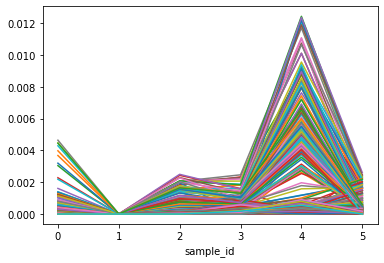

In [23]:
train_set_3.loc[:5,get_mz(0,train_set_3)].plot(legend=False);

In [24]:
def get_grads(df,bin_size):
    ''' returns gradients for each mz'''
    grad_df = pd.DataFrame(index=df.index)
    for mz in tqdm(range(0,100)):
        df_mz = df.loc[:,get_mz(mz,df)]
        # df_mz_col1 = df_mz.iloc[:,0].values
        df_mz = df_mz.diff(axis=1)
        # df_mz.iloc[:,0] = df_mz_col1
        df_mz.dropna(axis='columns',inplace=True)
        # df_mz = df_mz/bin_size
        df_mz.columns = [col[0]+ '_' + col[1] + '_' + 'grad' for col in df_mz.columns]
        grad_df = pd.concat([grad_df,df_mz],axis=1)

    return  grad_df

In [25]:
%%time
grad_3 = get_grads(train_set_3,3)
grad_200 = get_grads(train_set_200,200)
grad_50 = get_grads(train_set_50,50)
grad_5 = get_grads(train_set_5,5)
grad_500 = get_grads(train_set_500,500)
grad_100 = get_grads(train_set_100,100)

100%|██████████| 100/100 [00:01<00:00, 66.37it/s]

CPU times: user 29.7 s, sys: 471 ms, total: 30.1 s
Wall time: 29.9 s


In [26]:
%%time
grad_3_test = get_grads(test_set_3,3)
grad_200_test = get_grads(test_set_200,200)
grad_50_test = get_grads(test_set_50,50)
grad_5_test = get_grads(test_set_5,5)
grad_500_test = get_grads(test_set_500,500)
grad_100_test = get_grads(test_set_100,100)

100%|██████████| 100/100 [00:01<00:00, 76.48it/s]

CPU times: user 24 s, sys: 452 ms, total: 24.4 s
Wall time: 24.3 s


# add metadata
- mean,varience of all mzs
- mean,varience of a tempbin 

In [27]:
def get_mean_std(df):
    ''' returns mean and std for each mz'''
    mean_std_df = pd.DataFrame(index=df.index)
    for mz in tqdm(range(0,100)):
        df_mz = df.loc[:,get_mz(mz,df)]
        df_mz[f'{mz}_mean'] = df_mz.mean(axis=1)
        df_mz[f'{mz}_std'] = df_mz.std(axis=1)
        mean_std_df = pd.concat([mean_std_df,df_mz],axis=1)
    return mean_std_df

In [28]:
mean_std_3 = get_mean_std(train_set_3)
mean_std_5 = get_mean_std(train_set_5)
mean_std_50 = get_mean_std(train_set_50)
mean_std_100 = get_mean_std(train_set_100)
mean_std_200 = get_mean_std(train_set_200)
mean_std_500 = get_mean_std(train_set_500)

100%|██████████| 100/100 [00:00<00:00, 105.47it/s]


In [29]:
mean_std_3_test = get_mean_std(test_set_3)
mean_std_5_test = get_mean_std(test_set_5)
mean_std_50_test = get_mean_std(test_set_50)
mean_std_100_test = get_mean_std(test_set_100)
mean_std_200_test = get_mean_std(test_set_200)
mean_std_500_test = get_mean_std(test_set_500)

100%|██████████| 100/100 [00:00<00:00, 111.95it/s]


**next up**
- quantile transform, guassian rank transform , feature tools and nns

# cv

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
log_loss_scorer = make_scorer(log_loss, needs_proba=True)
phy = 'phyllosilicate'

In [31]:
logreg_clf = LogisticRegression(penalty='l1',C=1, solver='liblinear',random_state=RANDOM_SEED)
logreg_clf

LogisticRegression(C=1, penalty='l1', random_state=777, solver='liblinear')

In [32]:
def get_imp_coefs(clf,df,target_col):
    """
    Returns the df with imp cols based on logreg coefs...
    """
    clf.fit(df,targets[target_col])
    coefs = clf.coef_
    coefs = pd.Series(coefs.ravel())
    coefs = coefs.where(coefs != 0.0).dropna().sort_values(ascending=False).index
    # imp_fts_5[target_col] = coefs
    
    cv_score = cross_val_score(clf,df,targets[target_col],cv=skf,scoring=log_loss_scorer)
    print(cv_score,cv_score.mean())
    # print(target_col)
    # print(coefs)
    # print("------------------------------------")
    
    return df.iloc[:,coefs],coefs

In [33]:
# X_500 = pd.concat([train_set_500,grad_500,tot_abund_500,mean_std_500],axis=1)
# X_200 = pd.concat([train_set_200,grad_200,tot_abund_200,mean_std_200],axis=1)
# X_50 = pd.concat([train_set_50,grad_50,tot_abund_50,mean_std_50],axis=1)
# X_5 = pd.concat([train_set_5,grad_5,tot_abund_5,mean_std_5],axis=1)
# X_5.shape

In [34]:
def get_imp_coefs_for_tar(clf,df_set,tar):
    imp_df_1 = dict()
    imp_fts_1 = dict()
    
    imp_df_org,imp_fts_1['org_set'] = get_imp_coefs(clf,df_set[0],tar)
    imp_df_tot_abund,imp_fts_1['tot_abund_set'] = get_imp_coefs(clf,df_set[1],tar)
    imp_df_grad,imp_fts_1['grad_set'] = get_imp_coefs(clf,df_set[2],tar)
    imp_df_mean_std,imp_fts_1['mean_std_set'] = get_imp_coefs(clf,df_set[3],tar)

    imp_df_1 = pd.concat([imp_df_org,imp_df_tot_abund,imp_df_grad,imp_df_mean_std],axis=1)
    print(imp_df_1.shape)

    return imp_df_1,imp_fts_1

In [35]:
#  selecting fts each on additional datasets is best strategy

# c=5 l1 penality
# .25 from cb_clf on imp fts of x_500
# on whole x_500 directly fit on cb_clf (no imp fts) 0.26...


# .23 from cb_clf on individual imp fts of x_500 (73 fts)

# x_50 (131 fts) C =1
# (array([0.15715623, 0.19957427, 0.30083273, 0.2696438 , 0.18046425]),
#  0.22153425492556167,
#  0.054619214043050285)
# c = 5
# (array([0.16005222, 0.20716925, 0.30667596, 0.2675076 , 0.17654597]),
#  0.22359020020625892,
#  0.05541094180104098)

# X_5 (321) c = 5
# (array([0.2062453 , 0.23841005, 0.33270952, 0.28029341, 0.21285483]),
#  0.2541026221564036,
#  0.04712316089806101)




## get oof_train

In [36]:
NFOLDS = 5
ntrain = 1059
ntest = 804
RANDOM_SEED

777

In [37]:
df_set_3 = [train_set_3,tot_abund_3,grad_3,mean_std_3]
df_set_5 = [train_set_5,tot_abund_5,grad_5,mean_std_5]
df_set_50 = [train_set_50,tot_abund_50,grad_50,mean_std_50]
df_set_100 = [train_set_100,tot_abund_100,grad_100,mean_std_100]
df_set_200 = [train_set_200,tot_abund_200,grad_200,mean_std_200]
df_set_500 = [train_set_500,tot_abund_500,grad_500,mean_std_500]

In [38]:
df_test_set_3 = [test_set_3,tot_abund_3_test,grad_3_test,mean_std_3_test]
df_test_set_5 = [test_set_5,tot_abund_5_test,grad_5_test,mean_std_5_test]
df_test_set_50 = [test_set_50,tot_abund_50_test,grad_50_test,mean_std_50_test]
df_test_set_100 = [test_set_100,tot_abund_100_test,grad_100_test,mean_std_100_test]
df_test_set_200 = [test_set_200,tot_abund_200_test,grad_200_test,mean_std_200_test]
df_test_set_500 = [test_set_500,tot_abund_500_test,grad_500_test,mean_std_500_test]

In [39]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    cv_loss = []

    for i, (train_index, test_index) in enumerate(skf.split(x_train,y_train)):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]
        y_te = y_train.iloc[test_index]

        clf.fit(x_tr.values, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te.values)[:,1]
        fold_loss = log_loss(y_te, clf.predict_proba(x_te.values)[:,1])
        cv_loss.append(fold_loss)
        print(f"logloss for fold {i}: {fold_loss}")

        oof_test_skf[i, :] = clf.predict_proba(x_test.values)[:,1]

    print("CV ccv loss ",np.array(cv_loss).mean(),"CV ccv std", np.array(cv_loss).std())
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), np.array(cv_loss).mean()

In [40]:
oof_train_df = pd.DataFrame(index=metadata[metadata.split != 'test'].sample_id, columns=targets.columns)
oof_test_df = pd.DataFrame(index=metadata[metadata.split != 'train'].sample_id, columns=targets.columns)

In [41]:
def cvon_df(df_train_set,df_test_set,freq):
    imp_df  = dict()
    imp_fts = dict()
    
    agg_loss = []
    for target in targets.columns:
        print('target:',target)
        
        # select the best features for each target
        logreg_clf = LogisticRegression(penalty='l1',C=1, solver='liblinear',random_state=RANDOM_SEED)
        print('logreg cv score:')

        imp_df[target],imp_fts[target] = get_imp_coefs_for_tar(logreg_clf,df_train_set,target) # cv logreg

        X = imp_df[target]    # x is selected fts for the given target.
        X_test = pd.concat([
            df_test_set[0].iloc[:,imp_fts[target]['org_set']],
            df_test_set[1].iloc[:,imp_fts[target]['tot_abund_set']],
            df_test_set[2].iloc[:,imp_fts[target]['grad_set']],
            df_test_set[3].iloc[:,imp_fts[target]['mean_std_set']]
        ],axis=1)

        # save train and test sets 
        X.to_csv('X_'+freq+'_imp_v1_'+target+'.csv')
        X_test.to_csv('X_test_'+freq+'_imp_v1_'+target+'.csv')
        
        print("Caliberated catboost CV:")
        cb_clf = CatBoostClassifier(random_seed=RANDOM_SEED,verbose=False,eval_metric='Logloss')
        calb_clf = CalibratedClassifierCV(cb_clf,cv=skf,method='sigmoid')   # calibrating this way is calibrating on less data

        oof_train, oof_test, loss = get_oof(calb_clf,X,targets[target],X_test)
        agg_loss.append(loss)
#         print(loss)

        oof_train_df[target] = oof_train
        oof_test_df[target] = oof_test
        print('------------------------------------------------------------------------')
    
    dump(imp_df,'imp_df_'+ freq + '_v1.joblib')
    dump(imp_df,'imp_fts_'+ freq + '_v1.joblib')
    
    print('AGG Loss:',agg_loss)
    print("AGG Loss mean",np.array(agg_loss).mean())
    
    return oof_train_df,oof_test_df

In [42]:
# oof_train_3, oof_test_3 = cvon_df(df_set_3,df_test_set_3,'3')

In [43]:
# oof_train_3.to_csv('oof_train_3_v1.csv')
# oof_test_3.to_csv('oof_test_3_v1.csv')

In [44]:
oof_train_200, oof_test_200 = cvon_df(df_set_200,df_test_set_200,'200')

target: basalt
logreg cv score:
[0.29618601 0.34251172 0.33147642 0.3045623  0.30368469] 0.31568422627501647
[0.29744037 0.34430501 0.31667005 0.31142916 0.31604542] 0.3171780015725899
[0.30391862 0.33366086 0.33822246 0.30078298 0.29904712] 0.31512640635640254
[0.29616164 0.34246994 0.33219393 0.30454738 0.30363236] 0.31580104914857976
(1059, 74)
Caliberated catboost CV:
logloss for fold 0: 0.1358830946320037
logloss for fold 1: 0.14939754737414068
logloss for fold 2: 0.15679552664177998
logloss for fold 3: 0.17641164294523326
logloss for fold 4: 0.1711870593070472
CV ccv loss  0.15793497418004096 CV ccv std 0.014679757747536229
------------------------------------------------------------------------
target: carbonate
logreg cv score:
[0.29346799 0.24537882 0.24149702 0.33570706 0.25428965] 0.2740681090345786
[0.3120115  0.26306459 0.27503564 0.34983382 0.29931206] 0.299851523042478
[0.28829173 0.23241007 0.25131178 0.31154878 0.25044888] 0.26680224657321505
[0.27824139 0.22833238 0.2

In [45]:
oof_train_200.to_csv('oof_train_200_v1.csv')
oof_test_200.to_csv('oof_test_200_v1.csv')

In [46]:
# oof_train_5, oof_test_5 = cvon_df(df_set_5,df_test_set_5,'5')

In [47]:
# oof_train_5.to_csv('oof_train_5_v1.csv')
# oof_test_5.to_csv('oof_test_5_v1.csv')

In [48]:
# %%time
# oof_train_500, oof_test_500 = cvon_df(df_set_500,df_test_set_500,'500')

In [49]:
# oof_train_500.to_csv('oof_train_500_v1.csv')
# oof_test_500.to_csv('oof_test_500_v1.csv')